In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
from ForestDiffusion import ForestDiffusionModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif

# Step 1: Load your dataset (assuming X is the feature matrix and y is the target variable)
# Replace this with your data loading method
dataset='diabetes'
file_path = f'..\\..\\..\\Datasets\\Original Data\\{dataset}.csv'
data = pd.read_csv(file_path)

# Step 2: Inspect the data and check for class imbalance
# Assuming the last column is the label, and the rest are features
X = data.iloc[:, :-1].values  # Features
y = data.iloc[:, -1].values  # Labels (binary classification)

# Check and print the original class distribution
unique, counts = np.unique(y, return_counts=True)
class_dist_before = dict(zip(unique, counts))
print(f"Class distribution before augmentation: {class_dist_before}")

# Step 3: Plot the original imbalanced data (first two features for visualization)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', label='Original Data', s=1)
plt.title('Original Imbalanced Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()
# Separate the minority class
X_minority = X[y == 1]

# Step 2: Feature selection based on strongest correlation with the target
# Using SelectKBest to select top features correlated with target
selector = SelectKBest(score_func=f_classif, k=5)  # Adjust k based on the number of features to select
X_selected = selector.fit_transform(X, y)

# Get selected feature indices and names
selected_features = selector.get_support(indices=True)

# Step 3: Calculate the correlation matrix for the selected features of the minority class
X_selected_minority = X_minority[:, selected_features]
correlation_matrix = pd.DataFrame(X_selected_minority).corr()
print("Correlation Matrix of Selected Features:")
print(correlation_matrix)

# Function to make the correlation matrix positive definite if necessary
def make_positive_definite(matrix, epsilon=1e-5):
    """
    Adjusts the matrix to be positive definite by adding epsilon to the diagonal elements.
    
    Args:
        matrix (numpy.ndarray): The correlation matrix.
        epsilon (float): Small value to add to the diagonal to ensure positive definiteness.
    
    Returns:
        numpy.ndarray: Positive definite matrix.
    """
    # Check if the matrix is positive definite
    eigenvalues = np.linalg.eigvalsh(matrix)
    if np.all(eigenvalues > 0):
        return matrix
    
    # Add epsilon to the diagonal if not positive definite
    print("Adjusting matrix to be positive definite.")
    adjusted_matrix = matrix + np.eye(matrix.shape[0]) * epsilon
    
    # Re-check to confirm positive definiteness
    eigenvalues = np.linalg.eigvalsh(adjusted_matrix)
    assert np.all(eigenvalues > 0), "Failed to make the matrix positive definite."
    return adjusted_matrix

# Step 4: Ensure the correlation matrix is positive definite
positive_definite_corr_matrix = make_positive_definite(correlation_matrix.values)

# Step 5: Upsample the minority class using ForestDiffusionModel
int_columns = data.select_dtypes(include=['int']).columns
int_indexes = []
for col in int_columns:
    col_index = data.columns.get_loc(col)
        int_indexes.append(col_index)

# Assuming you have defined ForestDiffusionModel previously
forest_model = ForestDiffusionModel(X_minority, label_y=None, n_t=50, duplicate_K=100, 
                                    bin_indexes=[], cat_indexes=[], int_indexes=int_indexes, 
                                    diffusion_type='flow', n_jobs=-1)

X_minority_fake = forest_model.generate(batch_size=len(X) // 50)

# Function to adjust the correlations of the selected features in the generated data
def adjust_selected_correlation(X, target_corr_matrix, selected_features):
    """
    Adjusts the correlations of selected features in X to match the target correlation matrix.
    
    Args:
        X (numpy.ndarray): The dataset whose selected features' correlations need adjusting.
        target_corr_matrix (numpy.ndarray): The target correlation matrix for selected features.
        selected_features (list): List of indices for the selected features.
    
    Returns:
        numpy.ndarray: Dataset with adjusted correlations for the selected features.
    """
    # Extract only the selected features from X
    X_selected = X[:, selected_features]
    
    # Calculate the Cholesky decomposition of the target correlation matrix
    L = np.linalg.cholesky(target_corr_matrix)
    
    # Center the data for selected features
    X_selected_centered = X_selected - np.mean(X_selected, axis=0)
    
    # Transform the selected features to match the target correlation structure
    X_selected_transformed = np.dot(X_selected_centered, L.T) + np.mean(X_selected, axis=0)
    
    # Replace the selected features in the original dataset with the transformed features
    X_adjusted = X.copy()
    X_adjusted[:, selected_features] = X_selected_transformed
    
    return X_adjusted

# Step 6: Adjust the synthetic data to match the correlation structure of selected features
X_minority_fake_adjusted = adjust_selected_correlation(X_minority_fake, positive_definite_corr_matrix, selected_features)

# Step 7: Add the generated samples to the main imbalanced dataset
X_balanced = np.concatenate((X, X_minority_fake_adjusted), axis=0)
y_balanced = np.concatenate((y, np.ones(X_minority_fake_adjusted.shape[0])), axis=0)

# Check and print the class distribution after augmentation
unique_bal, counts_bal = np.unique(y_balanced, return_counts=True)
class_dist_after = dict(zip(unique_bal, counts_bal))
print(f"Class distribution after augmentation: {class_dist_after}")

# Step 8: Split the dataset into training and test sets (original and balanced)
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

# Step 9: Train a simple classifier on both original and generated datasets
clf_orig = RandomForestClassifier(random_state=42)
clf_orig.fit(X_train_orig, y_train_orig)

clf_bal = RandomForestClassifier(random_state=42)
clf_bal.fit(X_train_bal, y_train_bal)

# Step 10: Predict and calculate recall and F1 scores
y_pred_orig = clf_orig.predict(X_test_orig)
y_pred_bal = clf_bal.predict(X_test_orig)

recall_orig = recall_score(y_test_orig, y_pred_orig)
recall_bal = recall_score(y_test_orig, y_pred_bal)

f1_orig = f1_score(y_test_orig, y_pred_orig)
f1_bal = f1_score(y_test_orig, y_pred_bal)

# Step 11: Print the performance metrics
print(f"Recall score (original data): {recall_orig:.4f}")
print(f"Recall score (generated data): {recall_bal:.4f}")
print(f"F1 score (original data): {f1_orig:.4f}")
print(f"F1 score (generated data): {f1_bal:.4f}")

print("Classification Report (original data):\n", classification_report(y_test_orig, y_pred_orig))
print("Classification Report (generated data):\n", classification_report(y_test_orig, y_pred_bal))

# Step 12: Print the number of fake samples generated
print(f"Number of fake samples generated: {len(X_minority_fake_adjusted)}")

IndentationError: unexpected indent (3499407209.py, line 84)

Class distribution before augmentation: {-1: 9236, 1: 586}


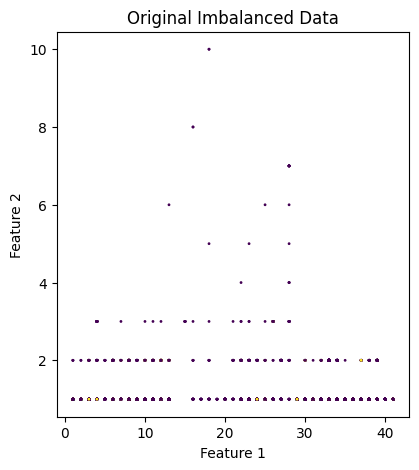

KeyboardInterrupt: 

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
from ForestDiffusion import ForestDiffusionModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif

# Step 1: Load your dataset (assuming X is the feature matrix and y is the target variable)
# Replace this with your data loading method
file_path = 'diabetes.csv'
data = pd.read_csv(file_path)

# Step 2: Inspect the data and check for class imbalance
# Assuming the last column is the label, and the rest are features
X = data.iloc[:, :-1].values  # Features
y = data.iloc[:, -1].values  # Labels (binary classification)

# Check and print the original class distribution
unique, counts = np.unique(y, return_counts=True)
class_dist_before = dict(zip(unique, counts))
print(f"Class distribution before augmentation: {class_dist_before}")

# Step 3: Plot the original imbalanced data (first two features for visualization)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', label='Original Data', s=1)
plt.title('Original Imbalanced Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()
# Separate the minority class
X_minority = X[y == 1]

# Step 2: Feature selection based on strongest correlation with the target
# Using SelectKBest to select top features correlated with target
selector = SelectKBest(score_func=f_classif, k=5)  # Adjust k based on the number of features to select
X_selected = selector.fit_transform(X, y)

# Get selected feature indices and names
selected_features = selector.get_support(indices=True)

# Step 3: Calculate the correlation matrix for the selected features of the minority class
X_selected_minority = X_minority[:, selected_features]
correlation_matrix = pd.DataFrame(X_selected_minority).corr()
print("Correlation Matrix of Selected Features:")
print(correlation_matrix)

# Function to make the correlation matrix positive definite if necessary
def make_positive_definite(matrix, epsilon=1e-5):
    """
    Adjusts the matrix to be positive definite by adding epsilon to the diagonal elements.
    
    Args:
        matrix (numpy.ndarray): The correlation matrix.
        epsilon (float): Small value to add to the diagonal to ensure positive definiteness.
    
    Returns:
        numpy.ndarray: Positive definite matrix.
    """
    # Check if the matrix is positive definite
    eigenvalues = np.linalg.eigvalsh(matrix)
    if np.all(eigenvalues > 0):
        return matrix
    
    # Add epsilon to the diagonal if not positive definite
    print("Adjusting matrix to be positive definite.")
    adjusted_matrix = matrix + np.eye(matrix.shape[0]) * epsilon
    
    # Re-check to confirm positive definiteness
    eigenvalues = np.linalg.eigvalsh(adjusted_matrix)
    assert np.all(eigenvalues > 0), "Failed to make the matrix positive definite."
    return adjusted_matrix

# Step 4: Ensure the correlation matrix is positive definite
positive_definite_corr_matrix = make_positive_definite(correlation_matrix.values)

# Step 5: Upsample the minority class using ForestDiffusionModel
int_columns = data.select_dtypes(include=['int']).columns
int_indexes = []
for col in int_columns:
    col_index = data.columns.get_loc(col)
    if col_index != 8:  # Skip column index 8
        int_indexes.append(col_index)

# Assuming you have defined ForestDiffusionModel previously
forest_model = ForestDiffusionModel(X_minority, label_y=None, n_t=50, duplicate_K=100, 
                                    bin_indexes=[], cat_indexes=[], int_indexes=int_indexes, 
                                    diffusion_type='flow', n_jobs=-1)

X_minority_fake = forest_model.generate(batch_size=len(X) // 50)

# Function to adjust the correlations of the selected features in the generated data
def adjust_selected_correlation(X, target_corr_matrix, selected_features):
    """
    Adjusts the correlations of selected features in X to match the target correlation matrix.
    
    Args:
        X (numpy.ndarray): The dataset whose selected features' correlations need adjusting.
        target_corr_matrix (numpy.ndarray): The target correlation matrix for selected features.
        selected_features (list): List of indices for the selected features.
    
    Returns:
        numpy.ndarray: Dataset with adjusted correlations for the selected features.
    """
    # Extract only the selected features from X
    X_selected = X[:, selected_features]
    
    # Calculate the Cholesky decomposition of the target correlation matrix
    L = np.linalg.cholesky(target_corr_matrix)
    
    # Center the data for selected features
    X_selected_centered = X_selected - np.mean(X_selected, axis=0)
    
    # Transform the selected features to match the target correlation structure
    X_selected_transformed = np.dot(X_selected_centered, L.T) + np.mean(X_selected, axis=0)
    
    # Replace the selected features in the original dataset with the transformed features
    X_adjusted = X.copy()
    X_adjusted[:, selected_features] = X_selected_transformed
    
    return X_adjusted

# Step 6: Adjust the synthetic data to match the correlation structure of selected features
X_minority_fake_adjusted = adjust_selected_correlation(X_minority_fake, positive_definite_corr_matrix, selected_features)

# Step 7: Add the generated samples to the main imbalanced dataset
X_balanced = np.concatenate((X, X_minority_fake_adjusted), axis=0)
y_balanced = np.concatenate((y, np.ones(X_minority_fake_adjusted.shape[0])), axis=0)

# Check and print the class distribution after augmentation
unique_bal, counts_bal = np.unique(y_balanced, return_counts=True)
class_dist_after = dict(zip(unique_bal, counts_bal))
print(f"Class distribution after augmentation: {class_dist_after}")

# Step 8: Split the dataset into training and test sets (original and balanced)
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

# Step 9: Train a simple classifier on both original and generated datasets
clf_orig = RandomForestClassifier(random_state=42)
clf_orig.fit(X_train_orig, y_train_orig)

clf_bal = RandomForestClassifier(random_state=42)
clf_bal.fit(X_train_bal, y_train_bal)

# Step 10: Predict and calculate recall and F1 scores
y_pred_orig = clf_orig.predict(X_test_orig)
y_pred_bal = clf_bal.predict(X_test_orig)

recall_orig = recall_score(y_test_orig, y_pred_orig)
recall_bal = recall_score(y_test_orig, y_pred_bal)

f1_orig = f1_score(y_test_orig, y_pred_orig)
f1_bal = f1_score(y_test_orig, y_pred_bal)

# Step 11: Print the performance metrics
print(f"Recall score (original data): {recall_orig:.4f}")
print(f"Recall score (generated data): {recall_bal:.4f}")
print(f"F1 score (original data): {f1_orig:.4f}")
print(f"F1 score (generated data): {f1_bal:.4f}")

print("Classification Report (original data):\n", classification_report(y_test_orig, y_pred_orig))
print("Classification Report (generated data):\n", classification_report(y_test_orig, y_pred_bal))

# Step 12: Print the number of fake samples generated
print(f"Number of fake samples generated: {len(X_minority_fake_adjusted)}")